In [0]:
#http://mlkd.csd.auth.gr/multilabel.html -> http://lpis.csd.auth.gr/publications/tsoumakas-mmd08.pdf   multi lable prediction paper 
# doesn't seem suitable 



# downloading data from drive 

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# bring the dataset from drive 

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloading dataset to colab 
# https://drive.google.com/open?id=1vQpharfx4IgnKDfejdYmFjkUoa_HtAYI
f_ = drive.CreateFile({'id': "1vQpharfx4IgnKDfejdYmFjkUoa_HtAYI"})
fname = "jobs_data_preprocced.csv"
f_.GetContentFile(fname)

# https://drive.google.com/open?id=1TM5UKcf-YZVkxa29ZDaR8w_BqK3gsg75
f_ = drive.CreateFile({'id': "1TM5UKcf-YZVkxa29ZDaR8w_BqK3gsg75"})
fname = "wiki-news-300d-1M-subword.vec.zip"
f_.GetContentFile(fname)


#in case you need to download multiple files from drive to colab 
'''
file_list = drive.ListFile(
    {'q': "'1kEMBmMLxO64LOd6jTUlgwiMqVbV2gBkE' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = f['title']
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  print( f['id'])
  f_.GetContentFile(fname)
'''

'\nfile_list = drive.ListFile(\n    {\'q\': "\'1kEMBmMLxO64LOd6jTUlgwiMqVbV2gBkE\' in parents"}).GetList()\n\nfor f in file_list:\n  # 3. Create & download by id.\n  print(\'title: %s, id: %s\' % (f[\'title\'], f[\'id\']))\n  fname = f[\'title\']\n  print(\'downloading to {}\'.format(fname))\n  f_ = drive.CreateFile({\'id\': f[\'id\']})\n  print( f[\'id\'])\n  f_.GetContentFile(fname)\n'

# Data preproccesing and embedding 


In [0]:
import pandas as pd 
from ast import literal_eval

def get_uniques(job_dataframe):
  jobtitles = job_dataframe['title'].tolist()
  job_functions = job_dataframe['jobFunction'].tolist()

  listjobfunc = job_dataframe['jobFunction'].apply(pd.Series).stack()
  print("get uniques : job_functions = " , len(job_functions))
  uniques = listjobfunc.unique()
  indexes = list(range(len(uniques)))
  di_job_functions = dict(zip(uniques, indexes))
  rev_dic_jobFun = dict(zip(indexes,uniques))

  print (len(di_job_functions))
  return jobtitles , job_functions , di_job_functions , rev_dic_jobFun

#----------
def single_jobfun_toNum(job_functions_dic , single_jobfunctions):
  lablejobfunc = []
  
  for function in single_jobfunctions:
    lablejobfunc.append (job_functions_dic[function])

  return lablejobfunc  

#-----------
def dataset_funtoNum(job_functions_dic, job_functions_list):
  labeled_ds = []
  print(type(job_functions_list), len(job_functions_list))
  for i in range( len(job_functions_list)) :
   sublist =single_jobfun_toNum(job_functions_dic , job_functions_list[i])
   
   labeled_ds.append(sublist)
  return labeled_ds

#-----------



In [3]:
from numpy import save
df  = pd.read_csv('jobs_data.csv')
# job functions colomn from strings to lists  
df.loc[:,'jobFunction'] = df.loc[:,'jobFunction'].apply(lambda x : literal_eval(x))
job_titles , job_funs ,job_functions_dict , rev_jobFun_dict= get_uniques(df)
save('job_functions_dict.npy',job_functions_dict)
save('rev_jobFun_dict.npy',rev_jobFun_dict)
#----------


print(job_titles[0])
#print(job_funs)
print(job_funs)
listO_funNumlists =  dataset_funtoNum(job_functions_dict , job_funs)
print(listO_funNumlists)

FileNotFoundError: ignored

In [0]:
print(job_titles[6800])

Property Sales Consultant - Real Estate


In [0]:
import numpy as np
# preprocessing : bellow arabic job titles are translated to english
def character_removal(text):
  charlist = "|&()[],\'\"-=+@/\\"
  for c in charlist : 
    text = text.replace(c,' ')
  return text  

def list_char_removal(X):
  for i in range(len(X)):
    X[i] = character_removal(X[i])
  
  return X  

# embedding
# word embedding model : https://fasttext.cc/docs/en/english-vectors.html
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

# embed_dict values are map object that can only be used once 
# in case a word appears twice in the dataser , the second occurence won't get a vector
# that's why each time I use the dict I add the vector to a backup dict 
def embed_title(embedding_dict , job_title,rownum,backup_dict):
  #backup_dict = {}
  title_vectors =np.zeros(shape=(10,300))
  if job_title is not None: 
    title_parts = job_title.split()
    print("job_title parts :",title_parts)
    for i , word  in enumerate(title_parts) :
      try:
        temp = list(embedding_dict[word])
        if temp == []:
          try :
            # value used before , check backup
            temp = backup_dict[word]
            title_vectors[i] = temp
          except Exception as e:
              # not used but not in the dictionary ,will stay as a zero vector 
              print (i," skipped : ",word ," Reason:" ,e )
        else: 
          # first usage , add to backup 
          backup_dict[word] = temp 
          title_vectors[i] = temp 
      except Exception as e:
        print("no embedding for : ",e)    
   
  else: 
    print(rownum,"title is null", job_title)   
  return title_vectors , backup_dict
  #figure out English word embedding 
  
# given the list of job function numbers it gives a 
def embed_func_row(row_functionlist , vectorlen):
  vector = np.zeros(vectorlen)
  #print("embed func:",row_functionlist)
  for fun_number in row_functionlist: 
    #print("embed func:" ,fun_number)
    vector [fun_number] = 1 
  return vector

# datasetX -> jobtitles    datasetY -> job functions turned to numbers 
def embed_dataset(datasetX ,datasetY,embed_dict ,fundict_len=38):
  length = len(datasetX)
  backup_dict = {}
  # so that each row is (10,300) and has as many rows and the dataset 10870
  arrX =np.zeros(shape=(length,10,300)) 
  #  38 unique job functions ; vector is 38 0s ,1s at jobfunctions indexes 
  arrY =np.zeros(shape=(length,1,fundict_len))
  for i in range (length):
    arrX[i],backup_dict = embed_title(embed_dict,datasetX[i],i,backup_dict)
    arrY[i] = embed_func_row(datasetY[i], fundict_len)

  return arrX , arrY

#def embid_prepredic(job_fun_1D , job_title, jobfun_dict):
#  fun_nums = single_jobfun_toNum(jobfun_dict , job_fun_1D)

In [0]:
vectorlen = len(job_functions_dict)
vector = embed_func_row(listO_funNumlists[0] , vectorlen)
print (vector) 

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Editing arabic titles 

In [0]:
letterstodetect = "ابتثجحخدذرزسشصضطظعغفقكلمنهويىلالآؤءئلأإألإة"
# figure out rows with arabic job titles 

#source : https://www.oreilly.com/library/view/python-cookbook/0596001673/ch03s07.html
def containsAny(str, set):
    """ Check whether sequence str contains ANY of the items in set. """
    return 1 in [c in str for c in set]
  
# function that takes the list of rows , loops over then and takes user input to replace them 
def list_arabic_titles_indexes(setofletters , stringlist): 
   stringindexlist =[]
   for i in range(len(stringlist)): 
     if containsAny(stringlist[i] , setofletters):
       stringindexlist.append(i)
   return stringindexlist    


def replace_arabic_titles  (stringindexlist , stringlist):
  for index in stringindexlist :
    print ("string to be replaced :   ", stringlist[index])
    newstring = input("replace string with :  ")
    stringlist[index] = newstring
  return stringlist  

In [0]:
letterstodetect = "ابتثجحخدذرزسشصضطظعغفقكلمنهويىلالآؤءئلأإألإة"

index_list = list_arabic_titles_indexes(letterstodetect,job_titles)
print(index_list)
job_titles = replace_arabic_titles  (index_list , job_titles)

[136, 230, 551, 755, 1282, 1297, 1421, 1442, 1467, 1668, 1758, 1996, 2290, 3179, 3530, 3556, 4124, 4507, 4516, 4826, 4865, 5159, 5736, 6628, 7055, 7510, 7607, 8514, 9094, 9292, 9303, 9804, 10171, 10569, 10629, 10859]
string to be replaced :    معلم لغة عربية
replace string with :  Arabic teacher
string to be replaced :    Dermatologist - دكتور جلدية
replace string with :  Dermatologist
string to be replaced :    Concrete Block Plant Operator - مشغل محطة طوب اسمنتي - العلمين
replace string with :  Concrete Block Plant Operator
string to be replaced :    Junior Administration / Facilities - مسئول إداري
replace string with :  Junior Administration / Facilities
string to be replaced :    Legal Affairs Officer - مسئول الشئون القانونية
replace string with :  Legal Affairs Officer
string to be replaced :    Legal Affairs Officer - مسئول الشئون القانونية
replace string with :  Legal Affairs Officer
string to be replaced :    Sales Representative - مندوب مبيعات
replace string with :  Sales Repr

In [0]:
print(job_titles[551])
print(listO_funNumlists[551])

Concrete Block Plant Operator
[23]


In [0]:

newdata = pd.DataFrame({"title":job_titles , 
                       "jobFunction":listO_funNumlists})
newdata.to_csv("jobs_data_preprocced.csv")    


In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


#model.save(".h5")
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = '1kEMBmMLxO64LOd6jTUlgwiMqVbV2gBkE'
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile('jobs_data_preprocced.csv')
f.Upload()

In [0]:
print (df)
print(job_titles)
print(X[500][2])

# Model 


In [7]:
# idea 1 : 1D CNN s ,word embedding for inputs
# highest 3 or less confidences above threshold where job functions are treated like 38 classes 
import keras
import random
from keras.models import Sequential
from keras.layers import Conv1D ,MaxPooling1D , Embedding,Flatten, Dropout , Dense , BatchNormalization
from keras.engine.input_layer import Input
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix

def create_model ():
  _filtersize = 300
  _fltrs = [  512,  512, 1024, 2048, 1024, 512,
              400, 300,  200, 100, 64, 64, 64]
  _kernal_size = 3
  _pool_size = 2
  _Learning_rate = .01
  _input_shape = (10,300)
  keras.backend.clear_session()
  model = Sequential()
  model.add(Conv1D(filters=_fltrs[0], kernel_size=_kernal_size, strides=1,
                   activation="relu",input_shape=_input_shape ))
  model.add(Conv1D(filters=_fltrs[1], kernel_size=_kernal_size, strides=1,  activation="relu"))
  model.add(BatchNormalization())
  #model.add(MaxPooling1D(pool_size=_pool_size, padding='same'))
  model.add(Conv1D(filters=_fltrs[2], kernel_size=_kernal_size, strides=1,  activation="relu"))
  model.add(Conv1D(filters=_fltrs[3], kernel_size=_kernal_size, strides=1,  activation="relu"))
  #model.add(Conv1D(filters=_fltrs[5], kernel_size=_kernal_size, strides=1,  activation="relu"))
  model.add(Dropout(.2))
  model.add(Flatten())
  model.add(Dense(38, activation = 'sigmoid'))
  opt = keras.optimizers.Adam(lr=_Learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);

  model.compile( loss='binary_crossentropy',
      optimizer=opt,
      metrics=['accuracy']
  )
  model.build(_input_shape)
  model.summary()
  return model   
  
def train_model(model , X_train , y_train):
  _batch_size = 64
  _epochs = 50
  Model_History = model.fit(X_train, y_train,
                              batch_size=_batch_size,
                              epochs=_epochs, validation_split=0.1,
                              shuffle=True)
  
  model.save("model_1.h5")
  return Model_History

def max_indexes(result,threshold=.5):
  maxindexs = [] 
  print("shape of result:",result)
  maxindexs.append(np.argmax(result,axis=1))
  result[maxindexs[0]] = 0
  for i in range(1,3):
    temp = np.argmax(result,axis=1)
    temp_confidence = result[temp]
    if not  temp_confidence > threshold:
      return maxindexs.sort()
    else :
      maxindexs.append(temp)
      results[maxindexs[0]] = 0
  return maxindexs.sort()

def test_model (model , X_test , y_test):
  predicted_y = model.predict(X_test)
  print(predicted_y[0])
  acc = accuracy_score(max_indexes(y_test,1), max_indexes(predicted_y,0.2))
  report = classification_report(max_indexes(y_test,1), max_indexes(predicted_y,0.2))
  cm = confusion_matrix(max_indexes(y_test,1), max_indexes(predicted_y,0.2))
  return cm, acc, report

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_model_history(history):
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

# Function calling using the new CSV 


In [10]:
!unzip wiki-news-300d-1M-subword.vec.zip

df  = pd.read_csv('jobs_data_preprocced.csv')
# job functions colomn from strings to lists
df.loc[:,'jobFunction'] = df.loc[:,'jobFunction'].apply(lambda x : literal_eval(x))
job_titles, job_funs,job_functions_dict , rev_dictFun = get_uniques(df)

dictlength = len(job_functions_dict)
job_titles =  list_char_removal(job_titles)
#print("unwanted charecters removed")

# call embedding functions
embed_dict = load_vectors("wiki-news-300d-1M-subword.vec")
print("dictionary loaded")
X , Y = embed_dataset(job_titles ,job_funs ,embed_dict, dictlength)
print(X[0],Y[0])
# cleared everytime because of the dictionary structer 
embed_dict.clear()
from numpy import save  
save("X.npy",X)
save("Y.npy",Y)
save("rev_dictFun.npy")


Archive:  wiki-news-300d-1M-subword.vec.zip
replace wiki-news-300d-1M-subword.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
get uniques : job_functions =  10870
38
dictionary loaded
job_title parts : ['Full', 'Stack', 'PHP', 'Developer']
job_title parts : ['CISCO', 'Collaboration', 'Specialist', 'Engineer']
job_title parts : ['Senior', 'Back', 'End', 'PHP', 'Developer']
job_title parts : ['UX', 'Designer']
job_title parts : ['Java', 'Technical', 'Lead']
job_title parts : ['Technical', 'Support', 'Engineer']
job_title parts : ['Senior', 'iOS', 'Developer']
job_title parts : ['Mechanical', 'Engineer']
job_title parts : ['Real', 'Estate', 'Sales', 'Specialist', '10th', 'of', 'Ramadan']
job_title parts : ['School', 'Principal']
job_title parts : ['Senior', 'Sales', 'Representative']
job_title parts : ['Accountant']
job_title parts : ['Indoor', 'Sales', 'Executive']
job_title parts : ['PHP', 'Full', 'Stack', 'Joomla', 'Expert']
job_title parts : ['English', 'Teacher', 'Assistant']
job_title 

TypeError: ignored

(10870, 10, 300)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 512)            461312    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 512)            786944    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 512)            2048      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 1024)           1573888   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 2048)           6293504   
___________________

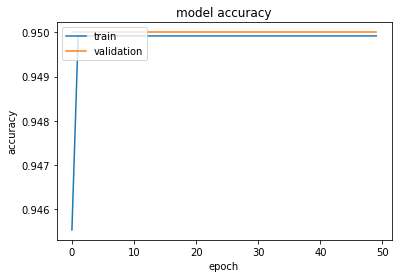

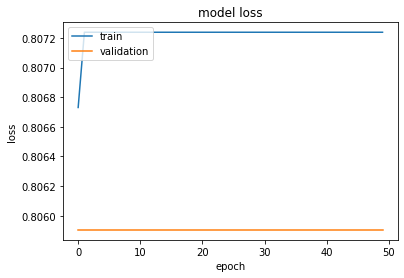

In [11]:
from sklearn.model_selection import train_test_split
from numpy import save  
from numpy import load 

X = load("X.npy")
Y = load("Y.npy")
print(X.shape)
Y = Y.reshape ((len(Y), 38))

X_train , X_test , Y_train , Y_test = train_test_split(X,Y , test_size = 0.2)
embed_dict.clear()
model = create_model()
Model_History = train_model(model , X_train , Y_train)
plot_model_history(Model_History)

   

In [25]:
if model is None: 
  model = keras.models.load("model_1.h5")  
array = np.zeros(shape=(1,10,300))
array = X_test[7]
print(X_test[7])
array = array.reshape(1,10,300)

print(model.predict(array))
print(y_test[7])
'''cm, acc, report = test_model(model , X_test , Y_test)
print ("accuracy:",acc)
print (report)
print (cm)'''

[[-0.0227 -0.0301 -0.0187 ... -0.0063  0.0125  0.0068]
 [ 0.0161  0.0089 -0.0102 ... -0.0202  0.0014 -0.0266]
 [ 0.0091  0.0045  0.0096 ... -0.0074  0.0188 -0.0126]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


NameError: ignored

# Uploading to google drive


In [0]:
#Download all files in gdrive folder
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


#model.save(".h5")
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
'''fid = '1naB_1sDhfr0YzClRoaYQLQWu5xFo1H-s'
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile('X.npy')
f.Upload()
#-----
fid = '1naB_1sDhfr0YzClRoaYQLQWu5xFo1H-s'
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile('Y.npy')
f.Upload()
#-----
fid = '1naB_1sDhfr0YzClRoaYQLQWu5xFo1H-s'
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile('model_1.h5')
f.Upload()'''
#-----
fid = '1naB_1sDhfr0YzClRoaYQLQWu5xFo1H-s'
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile('rev_jobFun_dict.npy')
f.Upload()

#-----
fid = '1naB_1sDhfr0YzClRoaYQLQWu5xFo1H-s'
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile('job_functions_dict.npy')
f.Upload()
